<a href="https://colab.research.google.com/github/iamYole/iamyole.github.io/blob/main/Replication_Pneumonia_Classification_Using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random

random.seed(0)

In [ ]:
# Install Kaggle and create a new kaggle directory
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [ ]:
# Upload the json key
from google.colab import files
files.upload()

In [ ]:
# Copy the file to the kaggle directory
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:10<00:00, 234MB/s]
100% 2.29G/2.29G [00:10<00:00, 231MB/s]


In [ ]:
!unzip /content/chest-xray-pneumonia.zip

In [ ]:
import numpy as np
import pandas as pd
import torch
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F 
from torch import nn,optim
from torchvision import transforms as T,datasets,models
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from collections import OrderedDict
from tqdm import tqdm
pd.options.plotting.backend = "plotly"
from torch import nn, optim
from torch.autograd import Variable

import time
import math

In [ ]:
def new_shape(width, filter, padding, stride):
    shape = (((width - filter) + 2*padding)/stride ) + 1
    return shape

def data_transforms(phase = None):
    
    if phase == TRAIN:

        data_T = T.Compose([
            
                T.Resize(size = (256,256)),
                T.RandomRotation(degrees = (-20,+20)),
                T.CenterCrop(size=224),
                T.ToTensor(),
                T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
    
    elif phase == TEST or phase == VAL:

        data_T = T.Compose([

                T.Resize(size = (224,224)),
                T.ToTensor(),
                T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
        
    return data_T

In [ ]:
data_dir = "../content/chest_xray"
TEST = 'test'
TRAIN = 'train'
VAL ='val'

trainset = datasets.ImageFolder(os.path.join(data_dir, TRAIN),transform = data_transforms(TRAIN))
testset = datasets.ImageFolder(os.path.join(data_dir, TEST),transform = data_transforms(TEST))
validset = datasets.ImageFolder(os.path.join(data_dir, VAL),transform = data_transforms(VAL))

In [ ]:
print(len(trainset))
print(len(testset))
print(len(validset))
print('img size = 224*224')

5216
624
16
img size = 224*224


In [ ]:
class_names = trainset.classes
print(class_names)
print(trainset.class_to_idx)

['NORMAL', 'PNEUMONIA']
{'NORMAL': 0, 'PNEUMONIA': 1}


In [ ]:
trainloader = DataLoader(trainset,batch_size = 64,shuffle = True)
validloader = DataLoader(validset,batch_size = 64,shuffle = True)
testloader = DataLoader(testset,batch_size = 64,shuffle = True)

images, labels = iter(trainloader).next()
v_img, v_lab = iter(validloader).next()
print(images.shape)
print(labels.shape)
print("---------Validation----------")
print(v_img.shape, v_lab.shape)

torch.Size([64, 3, 224, 224])
torch.Size([64])
---------Validation----------
torch.Size([16, 3, 224, 224]) torch.Size([16])


In [ ]:
for i, (images,labels) in enumerate(trainloader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())

In [ ]:
images.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [ ]:
class classify(nn.Module):
    def __init__(self,num_classes=2):
        super(classify,self).__init__()
        
         
        self.conv1=nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)   #224 * 224     
        self.bn1=nn.BatchNorm2d(num_features=12)
        self.relu1=nn.ReLU()        
        self.pool=nn.MaxPool2d(kernel_size=2) 

        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.relu3=nn.ReLU()

        self.fc=nn.Linear(in_features=32 * 112 * 112,out_features=num_classes)
        
        
        
        #Feed forwad function
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
        output=self.pool(output)
        output=self.conv2(output)
        output=self.relu2(output)
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)            
        output=output.view(-1,32*112*112)
        output=self.fc(output)
            
        return output
    
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
class classify7x7(nn.Module):
    def __init__(self,num_classes=2):
        super(classify7x7,self).__init__()
        
         
        self.conv1=nn.Conv2d(in_channels=3, out_channels=12, kernel_size=7, stride=1, padding=1)   #220 * 220     
        self.bn1=nn.BatchNorm2d(num_features=12)
        self.relu1=nn.ReLU()        
        self.pool=nn.MaxPool2d(kernel_size=2)                 

        self.conv2=nn.Conv2d(in_channels=12,out_channels=32,kernel_size=3,stride=1,padding=1)      #110 * 110
        self.relu2=nn.ReLU()
        
        self.conv3=nn.Conv2d(in_channels=32,out_channels=48,kernel_size=3,stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(num_features=48)
        self.relu3=nn.ReLU()
        self.pool2=nn.MaxPool2d(kernel_size=2)

        self.conv4 = nn.Conv2d(in_channels=48, out_channels=64, kernel_size=3, stride=1, padding=1)   #55 * 55
        self.bn4=nn.BatchNorm2d(num_features=64)
        self.relu4=nn.ReLU()       

        self.fc=nn.Linear(in_features=64 * 55 * 55,out_features=num_classes)
        
        
        
        #Feed forwad function
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
        output=self.pool(output)
        output=self.conv2(output)
        output=self.relu2(output)
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output) 
        output=self.pool2(output)  
        output =self.conv4(output)
        output=self.bn4(output)
        output=self.relu4(output)
        output=output.view(-1,64*55*55)
        output=self.fc(output)
            
        return output
    
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from torchsummary import summary
summary(classify().cuda(), (images.shape[1], images.shape[2], images.shape[3]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 12, 224, 224]             336
       BatchNorm2d-2         [-1, 12, 224, 224]              24
              ReLU-3         [-1, 12, 224, 224]               0
         MaxPool2d-4         [-1, 12, 112, 112]               0
            Conv2d-5         [-1, 20, 112, 112]           2,180
              ReLU-6         [-1, 20, 112, 112]               0
            Conv2d-7         [-1, 32, 112, 112]           5,792
       BatchNorm2d-8         [-1, 32, 112, 112]              64
              ReLU-9         [-1, 32, 112, 112]               0
           Linear-10                    [-1, 2]         802,818
Total params: 811,214
Trainable params: 811,214
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 27.95
Params size (MB): 3.09
Estimated 

In [ ]:
#!pip install torchsummary
from torchsummary import summary
summary(classify7x7().cuda(), (images.shape[1], images.shape[2], images.shape[3]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 12, 220, 220]           1,776
       BatchNorm2d-2         [-1, 12, 220, 220]              24
              ReLU-3         [-1, 12, 220, 220]               0
         MaxPool2d-4         [-1, 12, 110, 110]               0
            Conv2d-5         [-1, 20, 110, 110]           2,180
              ReLU-6         [-1, 20, 110, 110]               0
            Conv2d-7         [-1, 32, 110, 110]           5,792
       BatchNorm2d-8         [-1, 32, 110, 110]              64
              ReLU-9         [-1, 32, 110, 110]               0
           Conv2d-10         [-1, 48, 110, 110]          13,872
      BatchNorm2d-11         [-1, 48, 110, 110]              96
             ReLU-12         [-1, 48, 110, 110]               0
           Linear-13                    [-1, 2]       1,161,602
Total params: 1,185,406
Trainable param

In [ ]:
model = classify()
# defining the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)
# defining the loss function
criterion = nn.CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [ ]:
model = classify7x7()
# defining the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
# defining the loss function
criterion = nn.CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [ ]:
train_len = len(trainset)
num_epochs = 10
n_steps = math.ceil(train_len / 64)  #64 = BATCH_SIZE

In [ ]:
for i in range(30):
    running_loss = 0
    for images, labels in trainloader:
        
        #Changing images to cuda for gpu
        if torch.cuda.is_available():
          images = images.cuda()
          labels = labels.cuda()

        # Training pass
        # Sets the gradient to zero
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        # accumulates the loss for mini batch
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        Losses.append(loss)
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(i+1, running_loss/len(trainloader)))

path = 'content/saved_models/original_CNN.pth'
torch.save(model,path)

In [ ]:
print(f'[INFO] Training the network on {device} .........')

startTime = time.time()
Losses = []
training_losses = []
validation_losses = []


for epoch in range(num_epochs):
    model.train()                                              #puts the model in training mode
    running_loss = 0

    for step, (images, labels) in enumerate(trainloader):
        
        #Changing images to cuda for gpu
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

            # Training pass
            # Sets the gradient to zero
            optimizer.zero_grad()
            
            output = model(images)
            loss = criterion(output, labels)
            
            #This is where the model learns by backpropagating
            # accumulates the loss for mini batch
            loss.backward()
            
            #And optimizes its weights here
            optimizer.step()
            Losses.append(loss)
            
            running_loss += loss.item()
            
            if(step % 21) == 0:
                print(f'epoch {epoch+1}/{num_epochs}, step {step+1}/{n_steps},' 
                f'Training Loss = {(running_loss/len(trainloader)):.4f}')
                
    training_losses.append(loss.item())  #Appends the loss at the end of each epoch

    model.eval()
    val_loss = 0

    for (val_images, val_labels) in validloader:
        if torch.cuda.is_available():
            val_images = val_images.cuda()
            val_labels = val_labels.cuda()
        
        val_output = model(val_images)
        v_loss = criterion(val_output, val_labels)

        val_loss += v_loss.item()
        validation_losses.append(val_loss)

    print(f'[\nValidation Loss = { (val_loss / len(validloader)):.4f} \n]\n')

endTime = time.time()
print("\n\n[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))



path = 'content/saved_models/modified_CNN.pth'

torch.save(model,path)

[INFO] Training the network on cuda .........
epoch 1/10, step 1/82,Training Loss = 0.0022
epoch 1/10, step 22/82,Training Loss = 0.0361
epoch 1/10, step 43/82,Training Loss = 0.0612
epoch 1/10, step 64/82,Training Loss = 0.0901
[
Validation Loss = 1.2325 
]

epoch 2/10, step 1/82,Training Loss = 0.0018
epoch 2/10, step 22/82,Training Loss = 0.0361
epoch 2/10, step 43/82,Training Loss = 0.0662
epoch 2/10, step 64/82,Training Loss = 0.0930
[
Validation Loss = 1.4225 
]

epoch 3/10, step 1/82,Training Loss = 0.0012
epoch 3/10, step 22/82,Training Loss = 0.0224
epoch 3/10, step 43/82,Training Loss = 0.0528
epoch 3/10, step 64/82,Training Loss = 0.0776
[
Validation Loss = 1.3616 
]

epoch 4/10, step 1/82,Training Loss = 0.0005
epoch 4/10, step 22/82,Training Loss = 0.0271
epoch 4/10, step 43/82,Training Loss = 0.0494
epoch 4/10, step 64/82,Training Loss = 0.0746
[
Validation Loss = 1.4198 
]

epoch 5/10, step 1/82,Training Loss = 0.0016
epoch 5/10, step 22/82,Training Loss = 0.0260
epoch 5

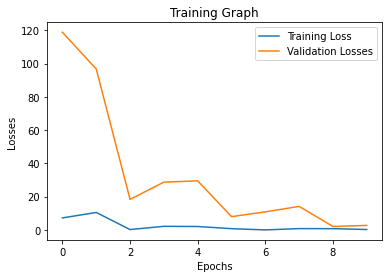

In [ ]:
plt.plot(training_losses, label = "Training Loss")
plt.plot(validation_losses, label = "Validation Losses")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend()
plt.title("Training Graph")
plt.show()

In [ ]:
correct_count, all_count = 0, 0
for images,labels in testloader:
  for i in range(len(labels)):
    if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
    img = images[i].view(1, 3, 224, 224)

    with torch.no_grad():
        logps = model(img)

    ps = torch.exp(logps)                                                          #Returns a new tensor with the exponential of the elements of the input tensor
    probab = list(ps.cpu()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.cpu()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", round((correct_count/all_count)*100,2),"%")

Number Of Images Tested = 624

Model Accuracy = 83.97 %


In [ ]:
import cv2 as cv

In [ ]:
model_weights = []                                                                # we will save the conv layer weights in this list
conv_layers = []                                                                  # we will save the conv layers in this list

# get all the model children as list
model_children = list(model.children())

In [ ]:
# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 4


In [ ]:
# take a look at the conv layers and the respective weights
for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

CONV: Conv2d(3, 12, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([12, 3, 7, 7])
CONV: Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([20, 12, 3, 3])
CONV: Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([32, 20, 3, 3])
CONV: Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([48, 32, 3, 3])


### Visualizing Convolutional Layer Filters

In [ ]:
cpu_model_weights = model_weights[0].to("cpu")

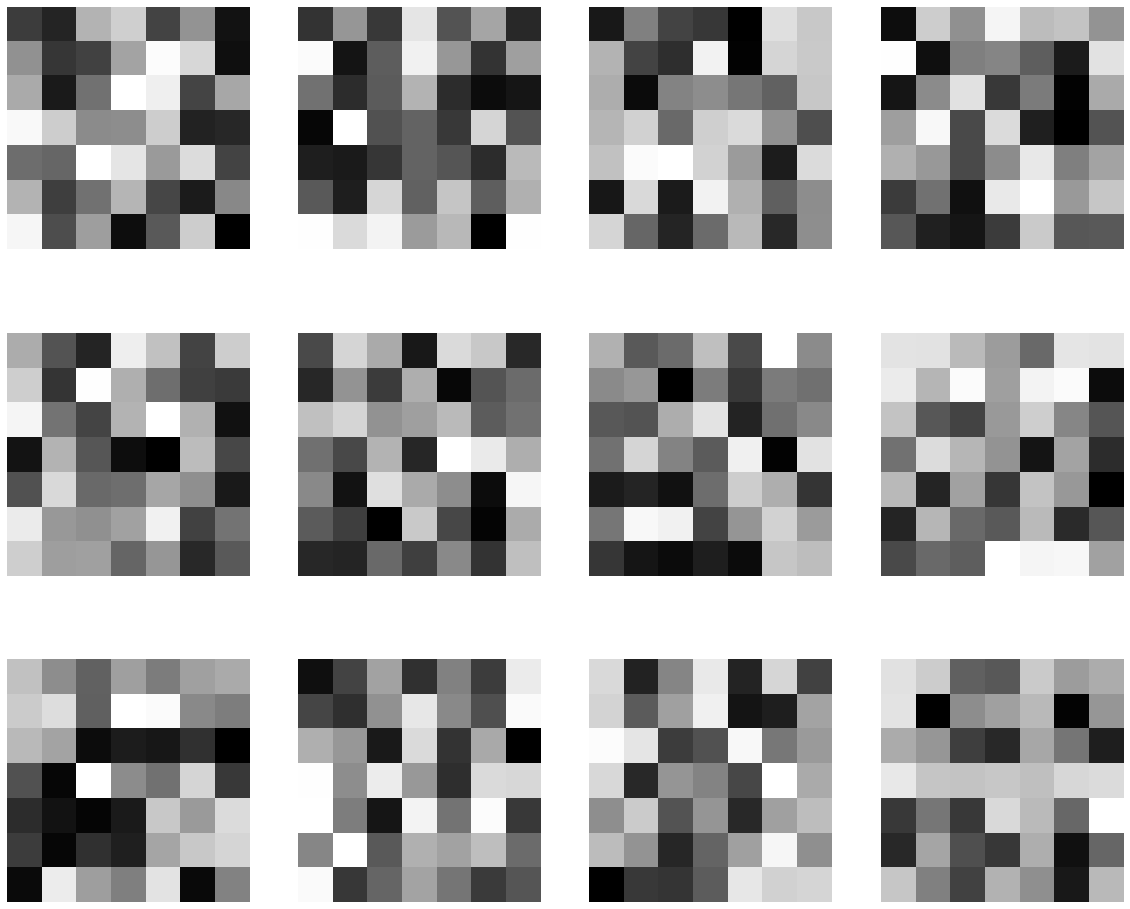

In [ ]:
# visualize the first conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(cpu_model_weights):
    plt.subplot(3, 4, i+1)                                                       # (3, 4) because in conv0 we have 3x3 filters and total of 12 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
    #plt.savefig('../outputs/filter.png')
plt.show()

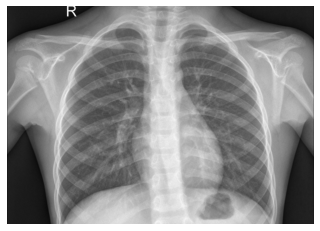

torch.Size([3, 512, 512])
torch.Size([1, 3, 512, 512])


In [ ]:
from torchvision.transforms.functional import resize
# read and visualize an image
img = cv.imread("/content/chest_xray/test/NORMAL/IM-0001-0001.jpeg")             #loads and image
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)                                         #converts to RGB
plt.imshow(img)
plt.axis('off')
plt.show()

# define the transforms
transform = T.Compose([
                        T.ToPILImage(),
                        T.Resize((512, 512)),
                        #T.Resize(size = (256,256)),
                        T.ToTensor(),
                    ])

img = np.array(img)
# apply the transforms
img = transform(img)
print(img.size())
# unsqueeze to add a batch dimension
img = img.unsqueeze(0)                                       
print(img.size())

In [ ]:
# pass the image through all the layers
img = img.to("cuda")                #Moves the tensore to GPU
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

torch.Size([12, 508, 508])


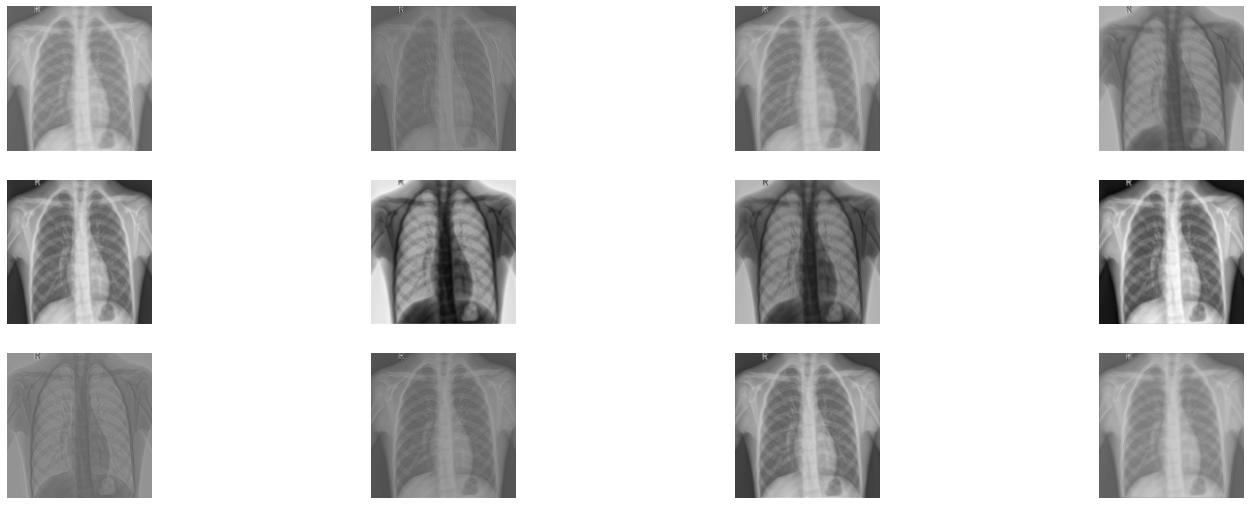

torch.Size([20, 508, 508])


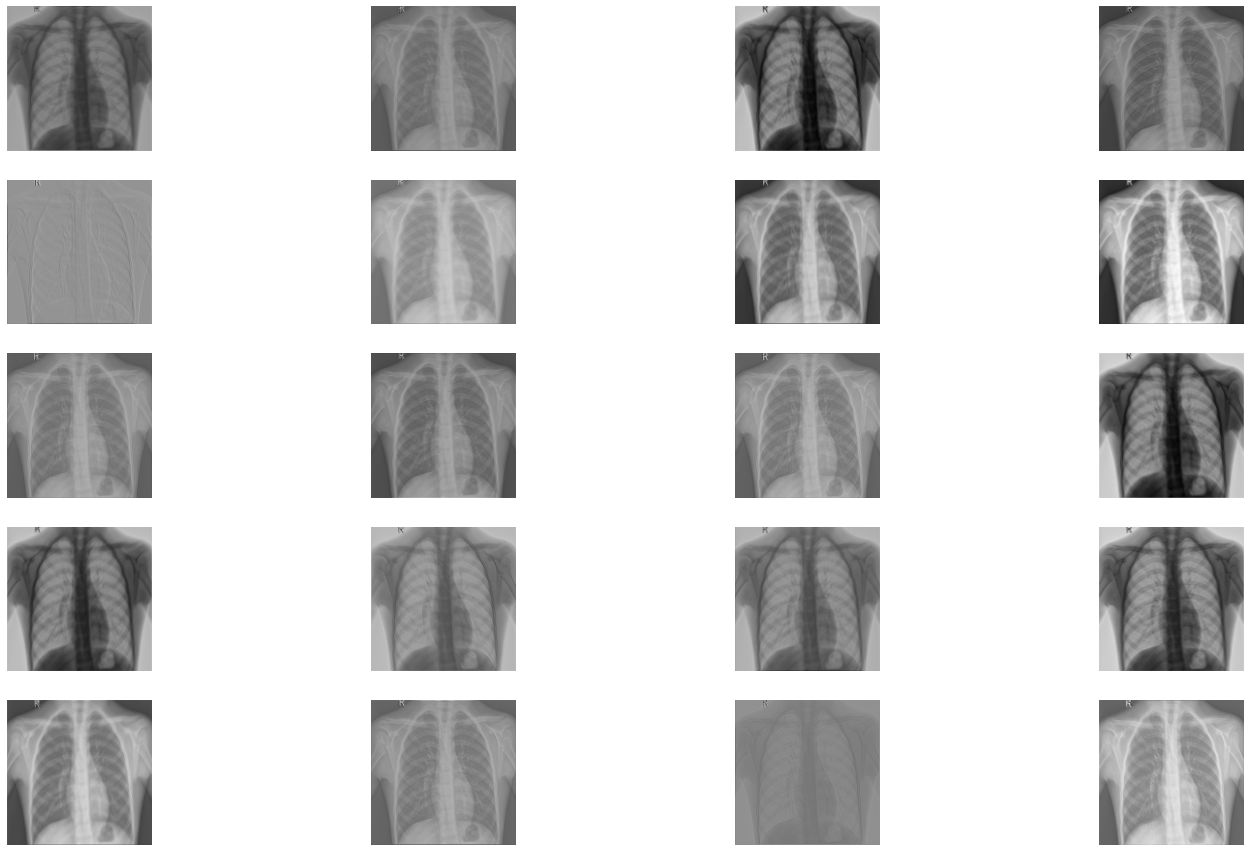

torch.Size([32, 508, 508])


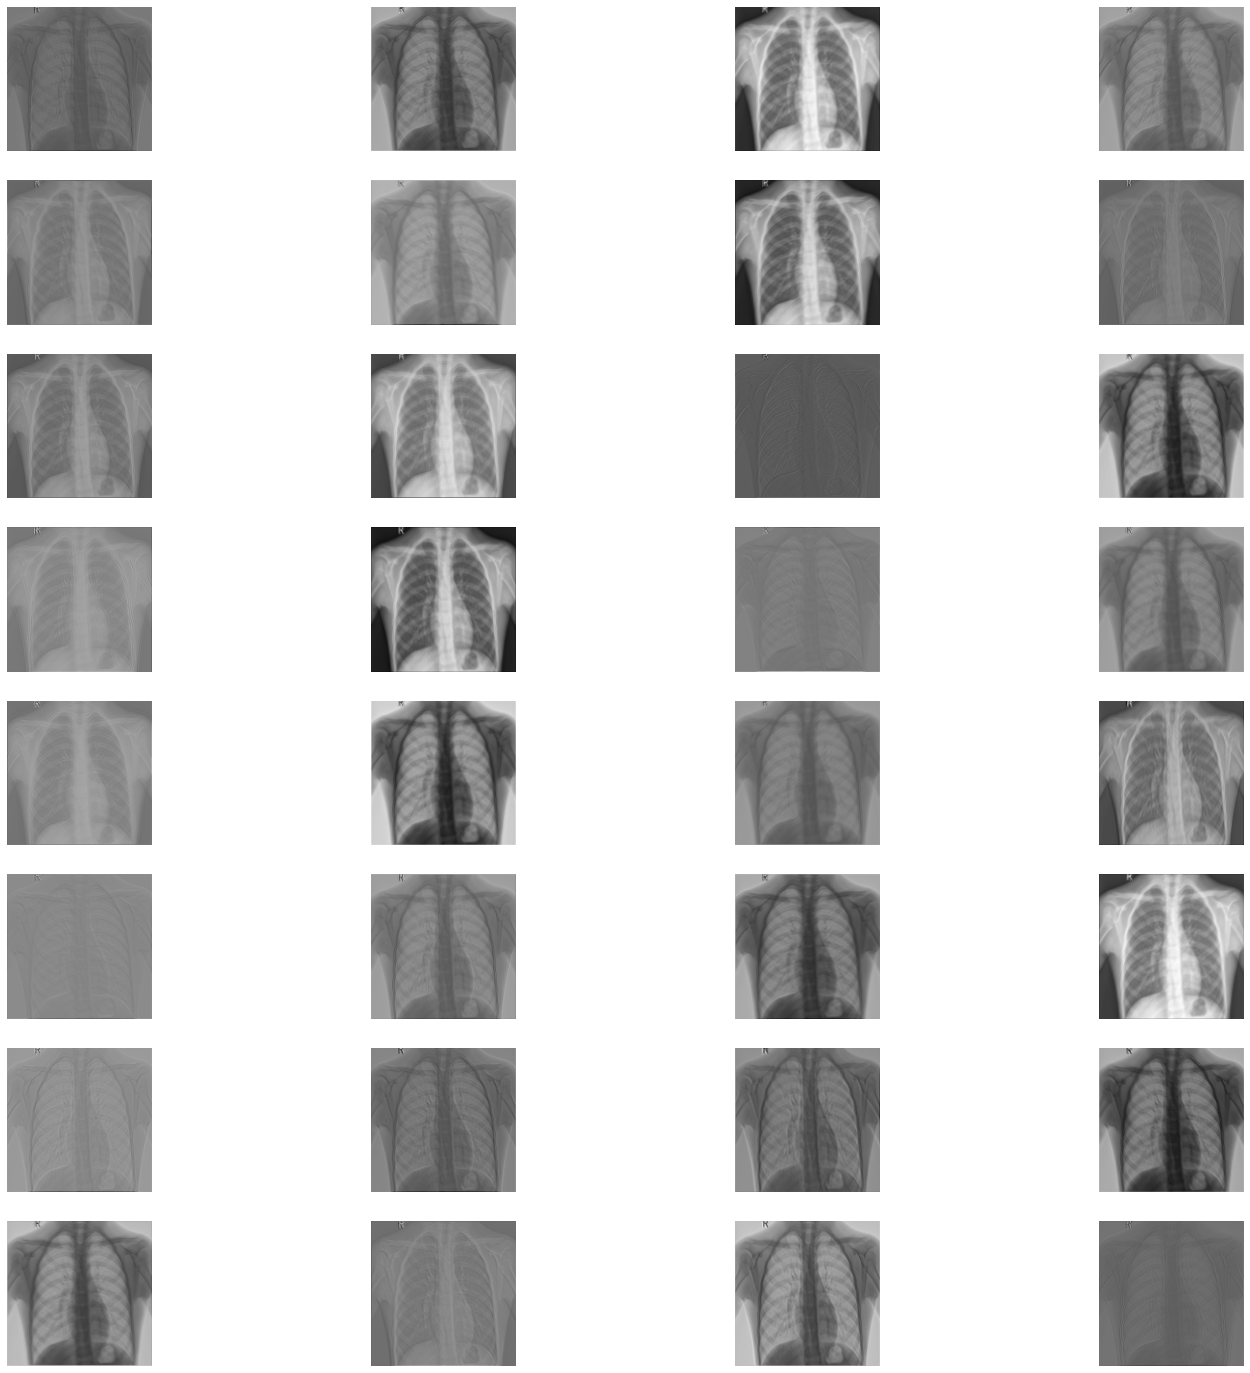

torch.Size([48, 508, 508])


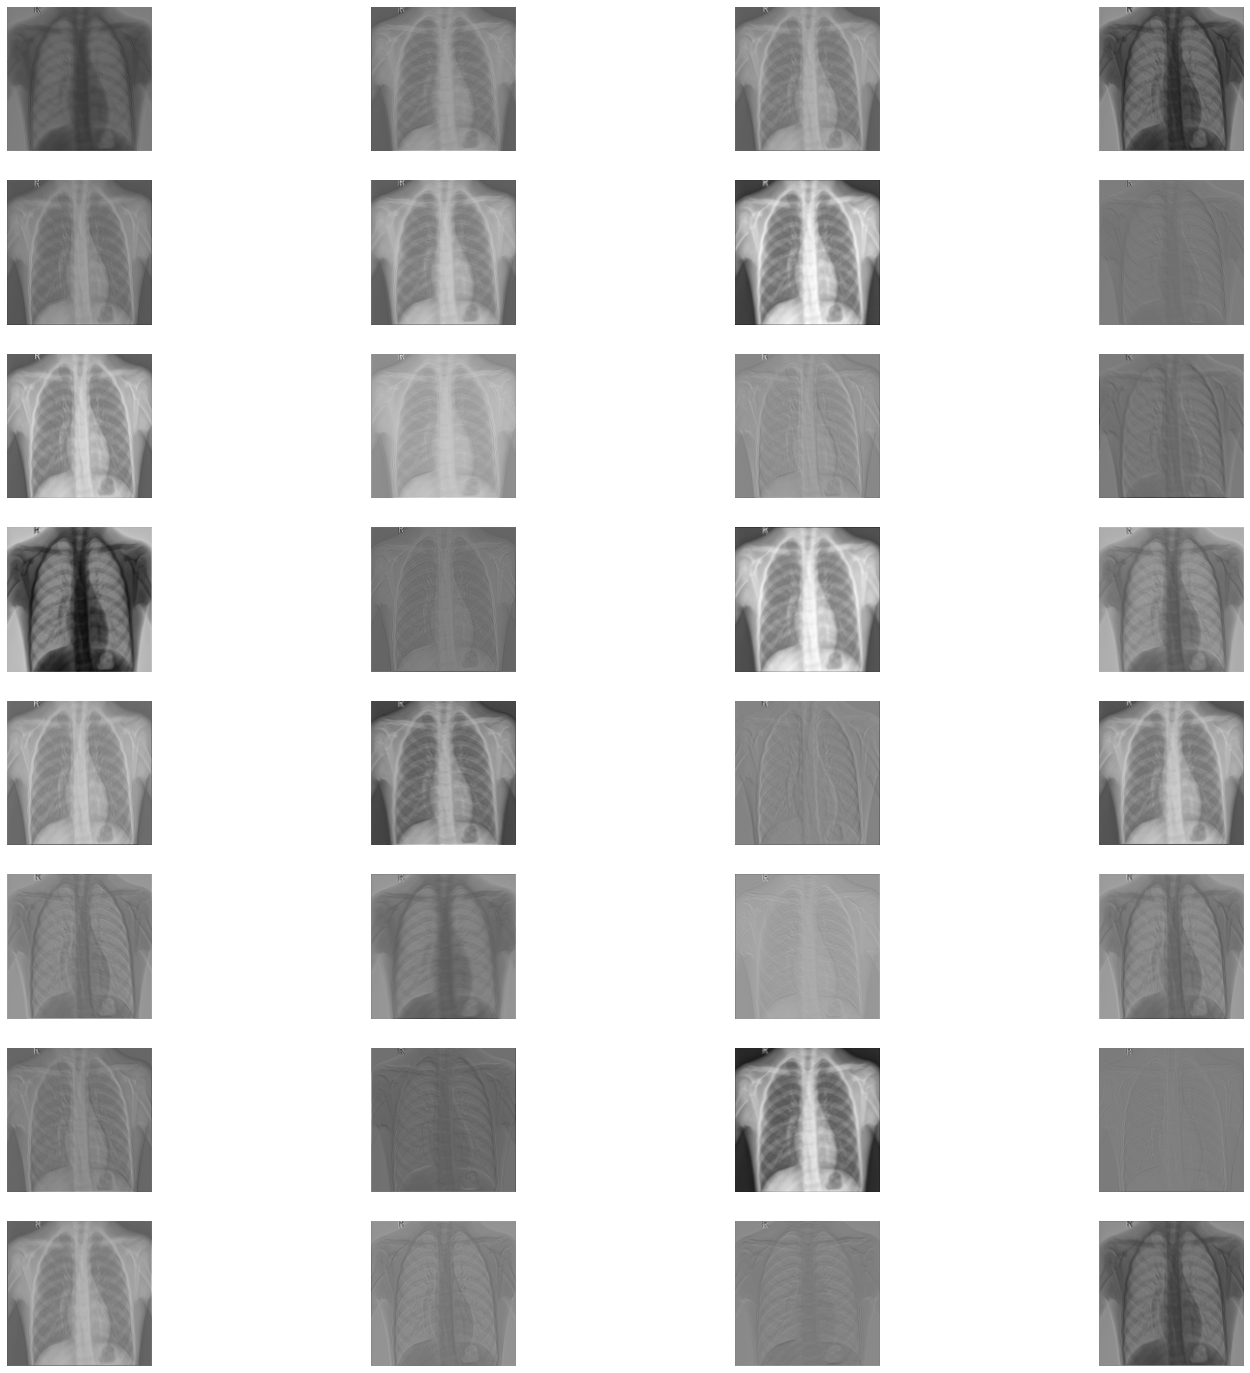

In [ ]:
# converts back to cpu
outputs_cpu = []
for i in range(len(outputs)):
    outputs_cpu.append(outputs[i].to("cpu"))

# visualize 64 features from each layer 
# (although there are more feature maps in the upper layers)
for num_layer in range(len(outputs_cpu)):
    plt.figure(figsize=(25, 25))
    layer_viz = outputs_cpu[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 32: #64: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(8, 4, i + 1)
        plt.imshow(filter, cmap='gray')
        plt.axis("off")
    #print(f"Saving layer {num_layer} feature maps...")
    #plt.savefig(f"../outputs/layer_{num_layer}.png")
    plt.show()
    plt.close()

In [ ]:
layer_viz.size()

torch.Size([32, 512, 512])